# Fellowship.ai Challenge

## ULMFiT sentiment analysis

<pre>
<img src='https://i.imgur.com/6yE0mOh.png', width=500>
</pre>

It works in three steps:


<ol>
    <li>Creating a Language mode (Wikitext)l</li>
    <li>Creating a Language Model (IMDB)</li>
    <li>Classifier</li>
</ol>

In [1]:
from fastai.text import *
from pathlib import Path

 
The data is been taken from the provided link of dataset-(https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv)
   In this dataset we have a file named as Tweets and in that file we have the data for the {airline_sentiment} and followed by its {text}. 

In [2]:
path = Path(".")
df = pd.read_csv('Tweets.csv', encoding = "ISO-8859-1")
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [3]:
data = df[['airline_sentiment', 'text']]

In [4]:
df['text'][1]

"@VirginAmerica plus you've added commercials to the experience... tacky."

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
airline_sentiment    14640 non-null object
text                 14640 non-null object
dtypes: object(2)
memory usage: 228.8+ KB


In [6]:
data.describe()

,airline_sentiment,text
count,14640,14640
unique,3,14427
top,negative,@united thanks
freq,9178,6


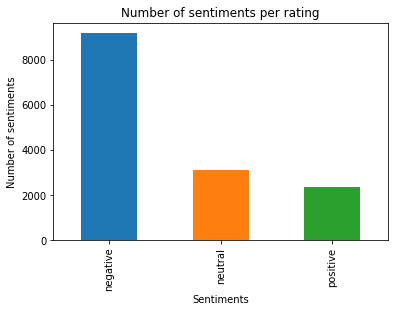

In [35]:
# Analyzing the data

data["airline_sentiment"].value_counts().plot.bar()
plt.title("Number of sentiments per rating")
plt.xlabel("Sentiments")
plt.ylabel("Number of sentiments")
plt.show()

In [8]:
# counting the values for negative,positive and neutral.

data["airline_sentiment"].value_counts()/len(data)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

We can see that the sentiments that we have here are imbalanaced. We have 62% negaitve sentiments, 21% neutral and 16% positive. 

## We will be performing two operations:

<ul>
    <li>Creating a Language model using an AWD LSTM model.</li>
    <li>Using the finetuned model as a classifier.</li>
</ul>
    

### Language Model

In [9]:
#batch size
bs = 48

# datablock for language model
data_lm = TextLMDataBunch.from_csv(path, 'Tweets.csv')

In [10]:
data_lm.show_batch()

idx,text
0,could n't get me too ... xxbos @usairways xxup us 728 stated their issues as : no one around to close said door . xxmaj more strange . xxmaj now we 're not hearing from pilot for long xxunk . xxbos @usairways this made me have to xxmaj cancelled xxmaj flight my car reservation and it came out to more money ... why did you reschedule a time without the
1,". xxbos @united i am a frequent user . xxmaj congrats u only lost my bags once in 20 years . xxmaj problem , it was today and your staff were xxunk still no bag ! xxbos @southwestair i receive bad customer service and ended up spending several hundred dollars to accommodate my family during each cxl flight xxbos @virginamerica xxmaj your planes are really pretty . xxmaj just thought"
2,need to be there 1 hour prior to boarding ? xxmaj thanks ! xxbos @usairways why the hell did you overbook a plane when you knew people actually had seat assignments . # inept # uncaring # piss poorplanning xxbos @southwestair how do i get my companion pass ? xxbos @ninadavuluri xxmaj we think it 's a treat to have you onboard ! xxmaj enjoy your flight . _ ùõª
3,friend flight got xxmaj cancelled xxmaj flightled . xxmaj how can he book be flight ? xxmaj leaving xxup chs to xxmaj philly to xxmaj xxunk xxbos @southwestair xxmaj you officially have the worst customer service of any airline i 've ever dealt with . # southwestairlines # poor xxbos @americanair i have been on hold w / customer service line for 68 minutes . xxmaj this after i was
4,'s yes please # xxunk . xxmaj oscar took it . xxbos @americanair - you broke my sick wife 's luggage handle going from xxup jfk to xxup lax ... she had to xxunk her bag thru the airport ! # customerservice xxbos @americanair * does = does n't xxbos @americanair my flight xxunk is xxmaj cancelled xxmaj flightled . xxmaj can you let me know what my new flight


## Finetune pretrained model 

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on tweets isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

In [11]:
# making the language_model

learn = language_model_learner(data_lm, AWD_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


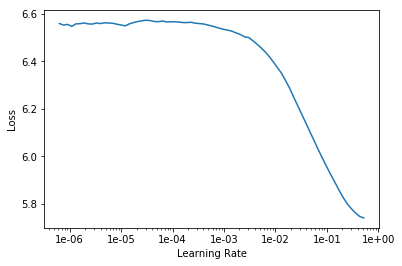

In [12]:
# finding the learning rate for training the model.

learn.lr_find()
learn.recorder.plot()

In [13]:
# Training the language_model.
learn.fit_one_cycle(5, 1e-01, moms=(0.2,0.4))

epoch,train_loss,valid_loss,accuracy,time
0,4.545799,4.195190,0.242109,00:25
1,4.364622,4.210177,0.245562,00:25
2,4.097713,4.090397,0.255370,00:25
3,3.716333,3.963692,0.272466,00:25
4,3.335369,3.945305,0.274856,00:25


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


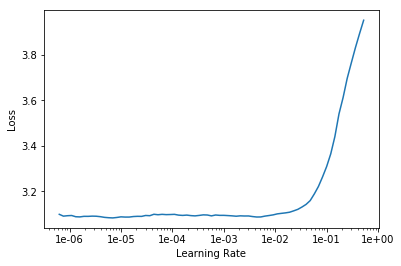

In [14]:
#unfreeze the model and fine-tunning it

learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(10, 6e-07, moms=(0.2,0.4))

epoch,train_loss,valid_loss,accuracy,time
0,3.104348,3.945407,0.275013,00:25
1,3.093906,3.945736,0.274803,00:25
2,3.098279,3.945854,0.274842,00:25
3,3.097522,3.946359,0.275013,00:25
4,3.098785,3.946657,0.274895,00:25
5,3.090050,3.946639,0.274882,00:25
6,3.098974,3.946516,0.275210,00:25
7,3.088603,3.946545,0.275302,00:25
8,3.092474,3.946461,0.275118,00:25
9,3.092131,3.947251,0.275013,00:25


In [16]:
# saving the encoded model.
learn.save_encoder('encoder_27%_accuracy')

## Classifier

In [17]:
# datablock for classifier

data_clas = TextClasDataBunch.from_csv(path, 'Tweets.csv', vocab=data_lm.train_ds.vocab, bs=32,
                                      text_cols='text', label_cols='airline_sentiment')

In [18]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
"xxbos @united xxmaj united xxmaj club team is xxup a+ & & got me a seat xxmaj late xxmaj flightr . xxmaj still , not sure why a last min xxup ual xxmaj cancelled xxmaj flightlation costs me $ yet overbooked folks get $ ?",negative
xxbos @usairways i do n't think the xxup us site allows that ( unlike http : / / t.co / etfjqiwuvt ) . xxmaj can i use a xxup us credit if i held on http : / / t.co / etfjqiwuvt ?,neutral
"xxbos @united ( 2 / 2 ) xxmaj it xxunk that if ca n't confirm cert at time of xxmaj flight xxmaj booking xxmaj problems , i should assume that it may never clear . xxmaj did n't used to be that way",negative
"xxbos @jetblue big shoutout to the crews on xxunk xxmaj bos > jfk & & xxunk jfk > roc , & & gate crews at c19 xxmaj bos & & 6 jfk . xxmaj long day of delays made better by them !",positive


In [19]:
# making the text_classifier and loding the encoded model.
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

# Using the pretrained encoder
learn.load_encoder('encoder_27%_accuracy')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11711 items)
x: TextList
xxbos @usairways 799 from xxup ams to xxup phl today- 3 of 4 flight attendants were xxunk rude and xxunk and made the 8 + hour flight even worse .,xxbos @americanair xxmaj do you happen to know if that plane will be xxunk , or fly " off into the sunset ? ",xxbos @united negative . xxmaj done wasting time with xxunk at customer service . xxmaj thanks for at least offering .,xxbos @southwestair xxup xxunk on xxmaj xxunk .,xxbos @usairways @jtrexsocial 5 hours on hold ... xxmaj safe to say no one is working .
y: CategoryList
negative,neutral,negative,neutral,negative
Path: .;

Valid: LabelList (2929 items)
x: TextList
xxbos @united xxunk out of xxmaj jackson , xxmaj xxunk ... xxmaj delayed by no pilots .. xxmaj full toilets .. xxmaj deplaned xxunk to mechanical fail .. xxmaj cancelled xxmaj flightled flight pending,xxbos @usairways i 've never been treated this badly,xxbos @southwestair delay is understandable 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


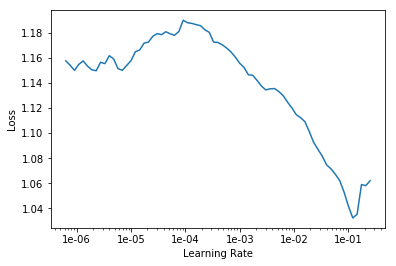

In [20]:
# Finding the learning rate for the classifier.
learn.lr_find()
learn.recorder.plot()

In [21]:
# Training the classifier
learn.fit_one_cycle(5, 3e-02, moms=(0.2,0.4))

epoch,train_loss,valid_loss,accuracy,time
0,0.783970,0.691079,0.735405,00:32
1,0.715517,0.658934,0.744281,00:31
2,0.734411,0.619373,0.746330,00:30
3,0.694346,0.589193,0.762718,00:34
4,0.714745,0.600321,0.756572,00:32


### Gradual Unfreezing

In [22]:
learn.fit_one_cycle(5, slice(1e-3/(2.6**4), 1e-3), moms=(0.2,0.4))

epoch,train_loss,valid_loss,accuracy,time
0,0.667518,0.592467,0.769204,00:31
1,0.646059,0.569679,0.780813,00:33
2,0.619315,0.543811,0.782520,00:32
3,0.647200,0.543362,0.786958,00:32
4,0.622370,0.543968,0.786617,00:32


In [23]:
learn.fit_one_cycle(5, slice(5e-3/(2.6**4), 5e-3), moms=(0.2,0.4))

epoch,train_loss,valid_loss,accuracy,time
0,0.614318,0.529959,0.795152,00:35
1,0.606750,0.509443,0.798907,00:34
2,0.538545,0.474188,0.815978,00:34
3,0.461520,0.481119,0.815295,00:34
4,0.369025,0.481842,0.817002,00:34


In [24]:
# saving or freezing the classifier 
learn.save('81.6%_accuracy')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


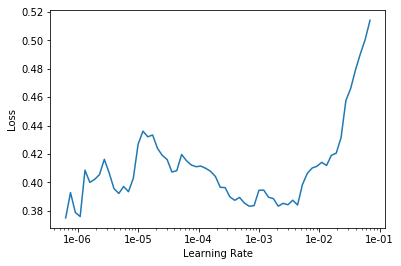

In [25]:
#unfreeze whole model and train
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [26]:
learn.fit_one_cycle(8, slice(1e-4/2*(2.6**4), 1e-4/2), moms=(0.2,0.4))

epoch,train_loss,valid_loss,accuracy,time
0,0.409556,0.486004,0.811540,00:35
1,0.401118,0.485030,0.810174,00:36
2,0.338077,0.502019,0.815295,00:37
3,0.293930,0.512078,0.812564,00:35
4,0.254118,0.520914,0.810174,00:36
5,0.205960,0.527319,0.811881,00:36
6,0.193286,0.516294,0.814954,00:38
7,0.178134,0.527190,0.810516,00:37


## Inference

In [31]:
# Declaring an array for the testing data and with its help predicting the sentiments of the reviews.

tests = [("Positive", "I loved the stewereds on the airline."),
        ("Negative", "I hated the food."),
        ("Negative", "Food was awesome but the flight got delayed which made my angry."),
        ("Positive", "Loved service."),
        ("Negetive", "The hygine is not up to the mark and there are foul smell in the flight."),
        ("Positive", "The delay is less and they provide great content to watch on the flight."),
        ("Positive", "The staff is friendly and well trained."),
        ("Negetive", "The online services are not well managed.")]


for rating, review in tests:
    prediction, _, _ = learn.predict(review)
    print(f"Original Rating: {rating}      Predicted rating: {prediction}")

Original Rating: Positive      Predicted rating: positive
Original Rating: Negative      Predicted rating: negative
Original Rating: Negative      Predicted rating: positive
Original Rating: Positive      Predicted rating: positive
Original Rating: Negetive      Predicted rating: negative
Original Rating: Positive      Predicted rating: negative
Original Rating: Positive      Predicted rating: positive
Original Rating: Negetive      Predicted rating: negative


Our Text Language Model seems to be working really good here. :)

## The End :)